In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [2]:
import keras
from keras import optimizers
from keras import losses
from keras import metrics
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.preprocessing import sequence

import numpy as np
from numpy import argmax

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
# unzipping the data
import zipfile
with zipfile.ZipFile('speed-dating-experiment.zip', 'r') as zip_ref:
    zip_ref.extractall('./data')

In [4]:
# loading the data
import pandas as pd
data = pd.read_csv('./data/Speed Dating Data.csv', engine='python')

In [5]:
# remove features that will not impact the match
data = data.drop(columns=['iid', 'pid', 'id', 'gender', 'idg', 'condtn', 'wave', 'round', 'position', 'positin1'])
# remove features with not enough data
data = data.drop(columns=[i for i in data.columns if (data[i].count() < 6000)])

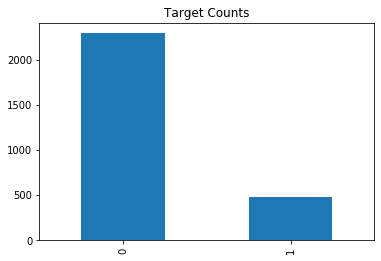

In [6]:
# drop rows with no data in 'match' column
data['match'] = pd.to_numeric(data['match'], errors='coerce')
data = data.dropna()

# display values in each class
target_count = data.match.value_counts()
target_count.plot(kind='bar', title='Target Counts')

# set aside labels as target vector
labels = list(data['match'])
labels = [int(i) for i in labels]
data = data.drop(columns=['match'])

# remove categorical features
cat_cols = [i for i in data.columns if data[i].dtype != 'float']
data = data.drop(columns=[i for i in cat_cols])

In [7]:
# update all columns to fill in blank values

In [8]:
# oversampling data to improve class balance
from imblearn.over_sampling import SMOTE
data_resampled, labels_resampled = SMOTE().fit_resample(data, labels)

In [9]:
print(data_resampled.shape)
print(labels_resampled.shape)

(4580, 92)
(4580,)


In [10]:
# split the data into train and test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data_resampled, labels_resampled, test_size=0.30)

In [11]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [12]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(3206, 92)
(1374, 92)
(3206, 2)
(1374, 2)


In [13]:
# create validation set
val_size = int(np.round(len(x_train)*.2))
x_val = x_train[:val_size]
x_train_minus_val = x_train[val_size:]

y_val = y_train[:val_size]
y_train_minus_val = y_train[val_size:]

In [14]:
x_val.shape

(641, 92)

In [33]:
# train basic RNN
rnn_model = Sequential()
rnn_model.add(Dense(128, activation='relu', input_shape=(92,)))
rnn_model.add(Dense(64, activation='relu'))
rnn_model.add(Dense(64, activation='relu'))
rnn_model.add(Dense(64, activation='relu'))
rnn_model.add(Dropout(.1))
rnn_model.add(Dense(2, activation='softmax')) 

rnn_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

rnn_history = rnn_model.fit(x_train_minus_val,
                    y_train_minus_val,
                    epochs=20,
                    batch_size=216,
                    validation_data=(x_val, y_val))

Train on 2565 samples, validate on 641 samples
Epoch 1/20
2565/2565 [==============================] - 1s 374us/step - loss: 1.3299 - acc: 0.5084 - val_loss: 0.7585 - val_acc: 0.5242
Epoch 2/20
2565/2565 [==============================] - 0s 21us/step - loss: 0.7174 - acc: 0.5669 - val_loss: 0.6379 - val_acc: 0.6443
Epoch 3/20
2565/2565 [==============================] - 0s 21us/step - loss: 0.6395 - acc: 0.6347 - val_loss: 0.5881 - val_acc: 0.6849
Epoch 4/20
2565/2565 [==============================] - 0s 21us/step - loss: 0.5746 - acc: 0.6990 - val_loss: 0.5362 - val_acc: 0.7504
Epoch 5/20
2565/2565 [==============================] - 0s 21us/step - loss: 0.5285 - acc: 0.7450 - val_loss: 0.4882 - val_acc: 0.7956
Epoch 6/20
2565/2565 [==============================] - 0s 21us/step - loss: 0.4891 - acc: 0.7559 - val_loss: 0.4563 - val_acc: 0.7988
Epoch 7/20
2565/2565 [==============================] - 0s 22us/step - loss: 0.4263 - acc: 0.8082 - val_loss: 0.4067 - val_acc: 0.8378
Epoch 8

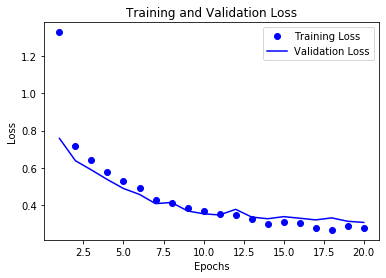

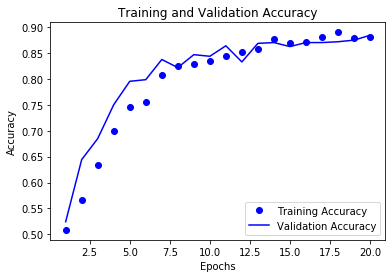

In [34]:
# accuracy and loss

loss = rnn_history.history['loss']
val_loss = rnn_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()
acc = rnn_history.history['acc']
val_acc = rnn_history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()